In [8]:
from maelzel.snd.audiosample import Sample, logger
import matplotlib.pyplot as plt
logger.setLevel("DEBUG")

Sample(dur=10.74281179138322, sr=44100, ch=1)
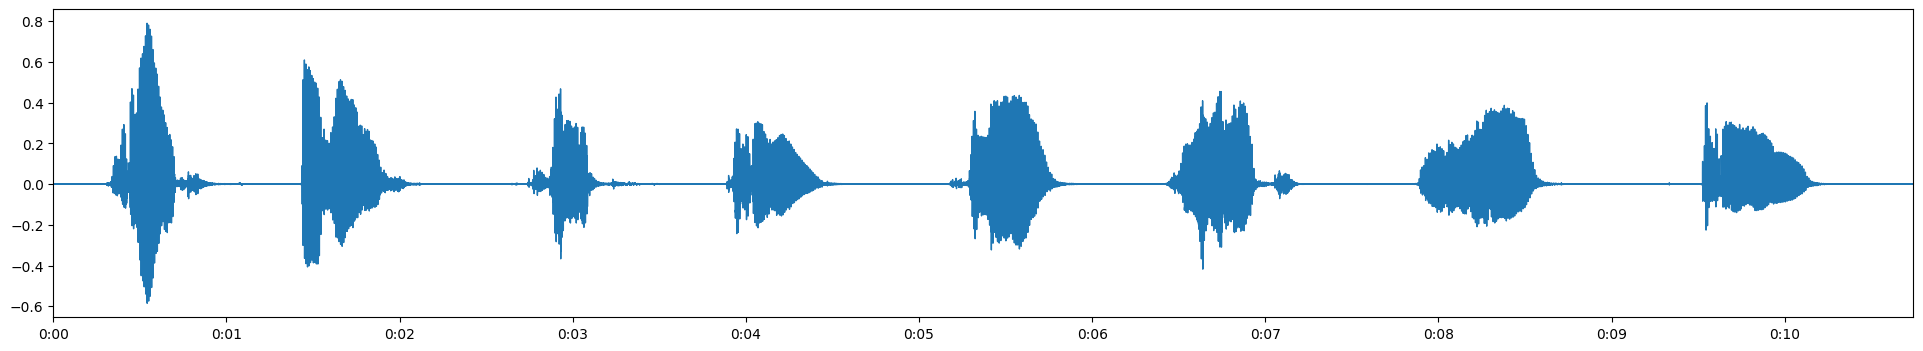

In [2]:
s = Sample("../snd/colours-german-male.flac")
s

In [6]:
s.play(speed=1, loop=True)

[maelzel.snd:audiosample.py:462:play:DEBUG] Playback using portaudio (sounddevice)


Button(description='Stop', style=ButtonStyle())

Output()

mnOut size: 926
m_pitchTrack size: 926


LibXtract compiled with ooura FFT


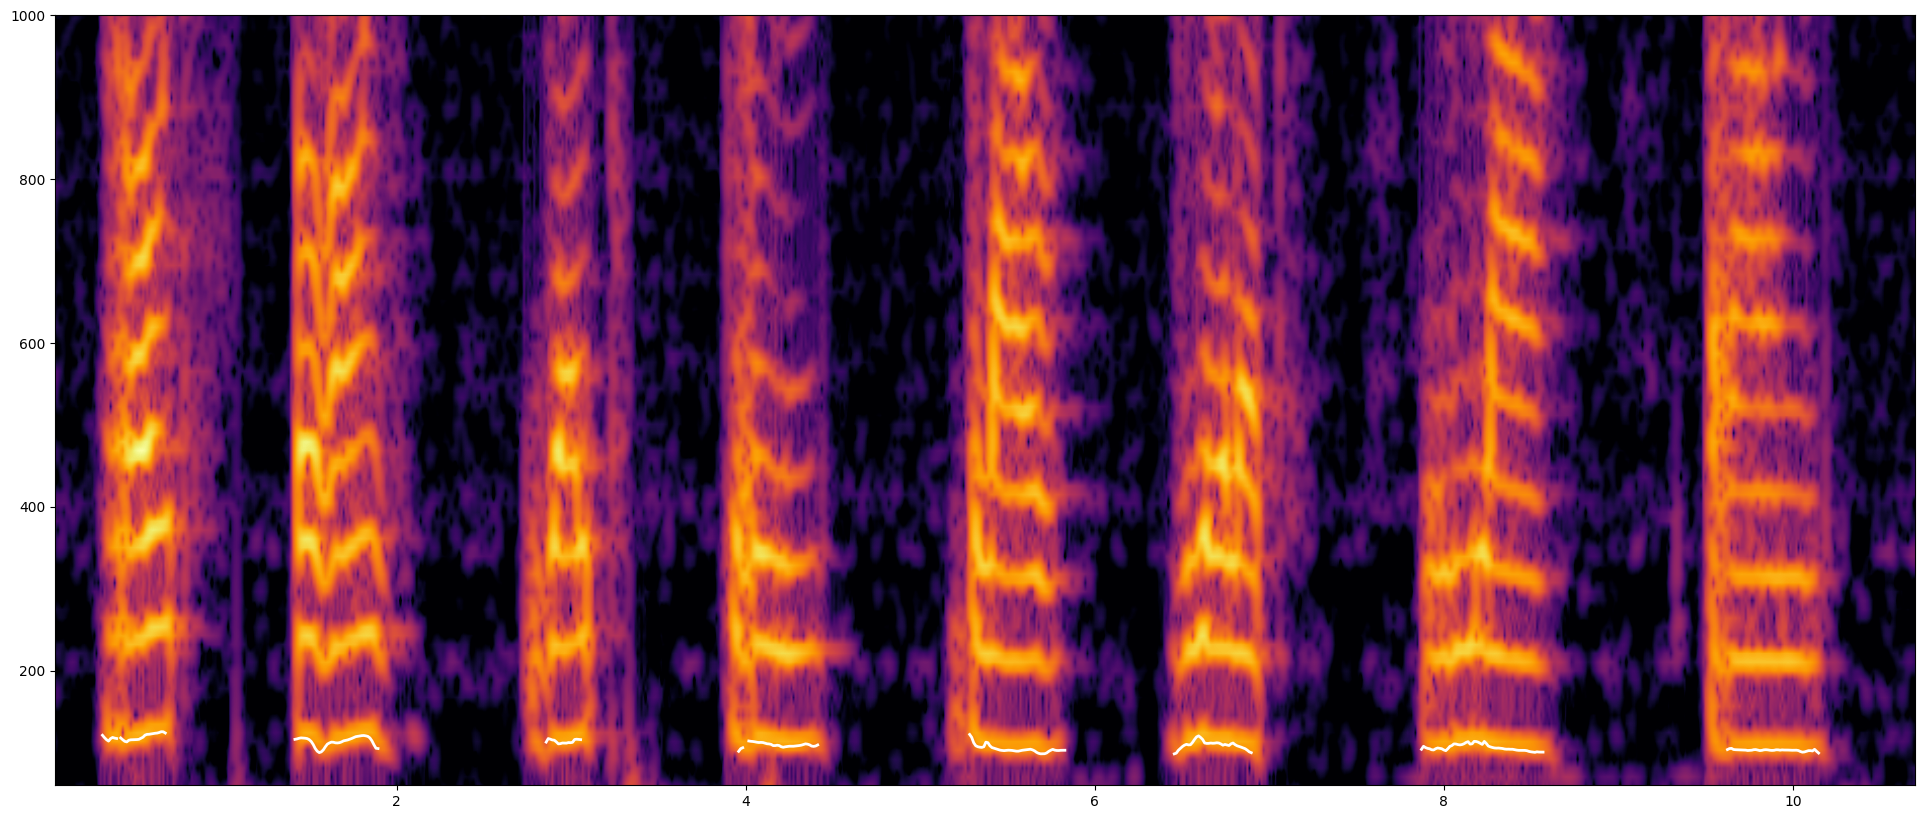

In [7]:
f0times, f0freqs = s.fundamental()

# Remove unvoiced parts
voiced = f0freqs.copy()
voiced[f0freqs < 0] = float('nan')

axes = s.plotSpectrogram(minfreq=60, maxfreq=1000, fftsize=4096, overlap=8)
axes.plot(f0times, voiced, linewidth=2, color='#ffffff')

Play the fundamental together with the soundfile to validate the tracking

In [9]:
import csoundengine as ce
session = ce.Session()
session.defInstr('vco', r'''
  |kfreq=1000, kamp=0.1|
  aamp = lag(interp(kamp), 0.01)
  asig = vco2:a(1, kfreq) * aamp
  asig *= linsegr:a(0, 0.05, 1, 0.05, 0)
  outch 1, asig
''')




--Csound version 6.19 (double samples) Jan 13 2024
[commit: c53556fbbb69d14554a4a4bd91efa441a1701d70]
libsndfile-1.2.0
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Pro: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Pro:
SECTION 1:


Instr(vco, kfreq:5=1000, kamp:6=0.1)

In [11]:
amps = (f0freqs > 0) * 0.1

with session:
    # Using the session as a context manager ensures that the events
    # scheduled are in sync
    session.playSample((s.samples, s.sr), pan=1)
    vco = session.sched('vco', dur=s.duration)
    vco.automate('kamp', (f0times, amps))
    vco.automate('kfreq', (f0times, f0freqs))
    